# Using Dask and dask-sql

## Credit: code from https://github.com/nils-braun/dask-sql and https://coiled.io/blog/getting-started-with-dask-and-sql/

##  Dask SQL docs https://dask-sql.readthedocs.io/

`dask-sql` 

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('df_panel_fix.csv')

In [4]:
df

,Unnamed: 0,province,specific,general,year,gdp,fdi,rnr,rr,i,fr,reg,it
0,0,Anhui,147002.0,NaN,1996,2093.30,50661,0.000000,0.000000,0.000000,1128873,East China,631930
1,1,Anhui,151981.0,NaN,1997,2347.32,43443,0.000000,0.000000,0.000000,1356287,East China,657860
2,2,Anhui,174930.0,NaN,1998,2542.96,27673,0.000000,0.000000,0.000000,1518236,East China,889463
3,3,Anhui,285324.0,NaN,1999,2712.34,26131,NaN,NaN,NaN,1646891,East China,1227364
4,4,Anhui,195580.0,32100.0,2000,2902.09,31847,0.000000,0.000000,0.000000,1601508,East China,1499110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355,Zhejiang,391292.0,260313.0,2003,9705.02,498055,1.214286,0.035714,0.035714,6217715,East China,2261631
356,356,Zhejiang,656175.0,276652.0,2004,11648.70,668128,1.214286,0.035714,0.035714,NaN,East China,3162299
357,357,Zhejiang,656175.0,NaN,2005,13417.68,772000,1.214286,0.035714,0.035714,NaN,East China,2370200
358,358,Zhejiang,1017303.0,394795.0,2006,15718.47,888935,1.214286,0.035714,0.035714,11537149,East China,2553268


In [5]:
from dask import dataframe as dd 

In [6]:
ddf = dd.from_pandas(df, npartitions=5)

In [7]:
ddf

,Unnamed: 0,province,specific,general,year,gdp,fdi,rnr,rr,i,fr,reg,it
npartitions=5,,,,,,,,,,,,,
0,int64,object,float64,float64,int64,float64,int64,float64,float64,float64,object,object,int64
72,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,...,...,...,...,...,...,...,...,...,...,...,...,...
359,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
from dask.distributed import Client

client = Client(processes=False, threads_per_worker=2,
                n_workers=3, memory_limit='4GB')
client

Client Scheduler: inproc://192.168.1.71/21359/1 Dashboard: http://192.168.1.71:8787/status,Cluster Workers: 3 Cores: 6 Memory: 12.00 GB


In [9]:
# client.restart()

Client Scheduler: inproc://192.168.1.71/21359/1 Dashboard: http://192.168.1.71:8787/status,Cluster Workers: 3 Cores: 6 Memory: 12.00 GB


In [13]:
ddf.groupby("province").gdp.mean().compute()

province
Anhui            3905.870000
Beijing          4673.453333
Chongqing        2477.712500
Fujian           4864.023333
Gansu            1397.832500
Guangdong       15358.781667
Guangxi          2924.104167
Guizhou          1422.010833
Hainan            686.714167
Hebei            6936.825000
Heilongjiang     4041.241667
Henan            7208.966667
Hubei            4772.503333
Hunan            4765.891667
Jiangsu         10761.846667
Jiangxi          2460.782500
Jilin            2274.854167
Liaoning         5231.135000
Ningxia           432.268333
Qinghai           383.099167
Shaanxi          2658.034167
Shandong        12324.002500
Shanghai         6432.454167
Shanxi           2817.210833
Sichuan          5377.790000
Tianjin          2528.665000
Tibet             170.426667
Xinjiang         1828.896667
Yunnan           2604.054167
Zhejiang         9138.151667
Name: gdp, dtype: float64

In [14]:
from dask_sql import Context

c = Context()

In [16]:
ddf

,Unnamed: 0,province,specific,general,year,gdp,fdi,rnr,rr,i,fr,reg,it
npartitions=5,,,,,,,,,,,,,
0,int64,object,float64,float64,int64,float64,int64,float64,float64,float64,object,object,int64
72,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,...,...,...,...,...,...,...,...,...,...,...,...,...
359,...,...,...,...,...,...,...,...,...,...,...,...,...


In [22]:
c.register_dask_table(ddf, "fiscal")

In [23]:
result = c.sql('SELECT count(1) FROM fiscal')

In [25]:
result

,COUNT(1)
npartitions=1,
,int64
,...


In [27]:
result.compute()

,COUNT(1)
0,360


In [30]:
result = c.sql("""
    SELECT
        province,
        gdp,
        fdi
    FROM
        fiscal AS fiscal
""")

In [31]:
result.compute()

,province,gdp,fdi
0,Anhui,2093.30,50661
1,Anhui,2347.32,43443
2,Anhui,2542.96,27673
3,Anhui,2712.34,26131
4,Anhui,2902.09,31847
...,...,...,...
355,Zhejiang,9705.02,498055
356,Zhejiang,11648.70,668128
357,Zhejiang,13417.68,772000
358,Zhejiang,15718.47,888935


In [33]:
print(result.compute())

     province       gdp      fdi
0       Anhui   2093.30    50661
1       Anhui   2347.32    43443
2       Anhui   2542.96    27673
3       Anhui   2712.34    26131
4       Anhui   2902.09    31847
..        ...       ...      ...
355  Zhejiang   9705.02   498055
356  Zhejiang  11648.70   668128
357  Zhejiang  13417.68   772000
358  Zhejiang  15718.47   888935
359  Zhejiang  18753.73  1036576

[360 rows x 3 columns]


In [20]:
from dask_sql import Context
from dask.datasets import timeseries

In [34]:
print(result.gdp.mean().compute())

4428.653416666667


In [35]:
result

,province,gdp,fdi
npartitions=5,,,
0,object,float64,int64
72,...,...,...
...,...,...,...
288,...,...,...
359,...,...,...


In [37]:
%%time
ddf.groupby("province").fdi.mean().compute()

CPU times: user 96.7 ms, sys: 1.99 ms, total: 98.7 ms
Wall time: 87.4 ms


province
Anhui           7.095308e+04
Beijing         2.573693e+05
Chongqing       4.112783e+04
Fujian          3.744664e+05
Gansu           5.295500e+03
Guangdong       1.194950e+06
Guangxi         5.514783e+04
Guizhou         5.812333e+03
Hainan          6.436600e+04
Hebei           1.322308e+05
Heilongjiang    8.271933e+04
Henan           9.442600e+04
Hubei           1.497132e+05
Hunan           1.321102e+05
Jiangsu         8.736957e+05
Jiangxi         1.037352e+05
Jilin           4.122658e+04
Liaoning        2.859253e+05
Ningxia         3.950417e+03
Qinghai         1.098408e+04
Shaanxi         5.089258e+04
Shandong        5.455843e+05
Shanghai        5.082483e+05
Shanxi          3.862883e+04
Sichuan         6.219717e+04
Tianjin         2.501733e+05
Tibet           8.397500e+02
Xinjiang        4.433083e+03
Yunnan          1.704833e+04
Zhejiang        4.259302e+05
Name: fdi, dtype: float64

In [38]:
%%time
c.sql('SELECT avg(fdi) FROM fiscal GROUP BY province').compute()

CPU times: user 206 ms, sys: 5.58 ms, total: 212 ms
Wall time: 176 ms


,"AVG(""fiscal"".""fdi"")"
0,70953
1,257369
2,41127
3,374466
4,5295
5,1194950
6,55147
7,5812
8,64366
9,132230


In [39]:
dfp = ddf.persist()

In [40]:
import distributed

In [42]:
cached_tasks = distributed.wait(dfp)
print(f'cached {len(cached_tasks[0])} results')

cached 5 results


In [44]:
c.register_dask_table(dfp, "fiscal_cached")

In [45]:
result = c.sql('SELECT count(1) FROM fiscal_cached')
result.compute()

,COUNT(1)
0,360


In [46]:
%%time

c.sql('SELECT avg(fdi) FROM fiscal GROUP BY province').compute()

CPU times: user 208 ms, sys: 12.9 ms, total: 221 ms
Wall time: 162 ms


,"AVG(""fiscal"".""fdi"")"
0,70953
1,257369
2,41127
3,374466
4,5295
5,1194950
6,55147
7,5812
8,64366
9,132230


In [49]:
c.sql('SELECT floor(3.14)').compute()

,FLOOR(3.14)
0,3.0


In [50]:
%%time

c.sql("""
    SELECT floor(fdi) AS fdi, avg(gdp) as gdp, count(1) as fiscal_count
    FROM fiscal_cached 
    WHERE fdi > 50 AND gdp >= 0 
    GROUP BY floor(fdi)
""").compute()

distributed.utils_perf - WARNING - full garbage collections took 92% CPU time recently (threshold: 10%)


CPU times: user 356 ms, sys: 20.4 ms, total: 376 ms
Wall time: 308 ms


,fdi,gdp,fiscal_count
0,2000,1933.98,1
1,2342,1399.83,1
2,2954,2277.35,1
3,3539,1688.49,1
4,3864,887.67,1
...,...,...,...
354,527776,5252.76,1
355,668128,11648.70,1
356,772000,13417.68,1
357,888935,15718.47,1


And now we can run a query and immediately plot a visualization of the result using Pandas plotting syntax!

<AxesSubplot:xlabel='fdi'>

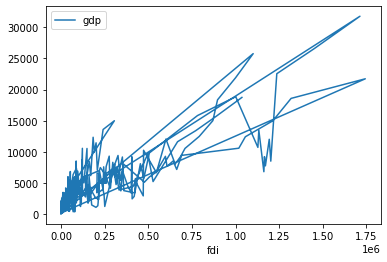

In [51]:
c.sql("""
    SELECT floor(fdi) AS fdi, avg(gdp) as gdp
    FROM fiscal_cached 
    WHERE fdi > 50 AND gdp >= 0 
    GROUP BY floor(fdi)
""").compute().plot(x='fdi', y='gdp')